In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings(action='ignore')
plt.style.use('fivethirtyeight')
import featuretools as ft
import dask.dataframe as dd
import gc
gc.enable()

#### Importing the dataset

###### Using dask



With Dask and its dataframe construct, you set up the dataframe must like you would in pandas but rather than loading the data into pandas, this approach keeps the dataframe as a sort of ‘pointer’ to the data file and doesn’t load anything until you specifically tell it to do so.

Source: http://pythondata.com/dask-large-csv-python/



In [2]:
%time

train_d=dd.read_csv('/home/shahul/my Datasets/kaggle/pubg/train_V2.csv',blocksize=25e6)



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.63 µs


###### Using pandas

In [3]:
train=pd.read_csv('/home/shahul/my Datasets/kaggle/pubg/train_V2.csv',nrows=50000)
test=pd.read_csv("/home/shahul/my Datasets/kaggle/pubg/test_V2.csv",nrows=20000)


In [4]:
test_id=test['Id']

#### Basic description of the data

In [5]:
print('size of the training data',train.shape)

size of the training data (50000, 29)


There are 26 columns in our training data.

In [6]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [7]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
Id                 50000 non-null object
groupId            50000 non-null object
matchId            50000 non-null object
assists            50000 non-null int64
boosts             50000 non-null int64
damageDealt        50000 non-null float64
DBNOs              50000 non-null int64
headshotKills      50000 non-null int64
heals              50000 non-null int64
killPlace          50000 non-null int64
killPoints         50000 non-null int64
kills              50000 non-null int64
killStreaks        50000 non-null int64
longestKill        50000 non-null float64
matchDuration      50000 non-null int64
matchType          50000 non-null object
maxPlace           50000 non-null int64
numGroups          50000 non-null int64
rankPoints         50000 non-null int64
revives            50000 non-null int64
rideDistance       50000 non-null float64
roadKills          50000 non-null int64
s

##### Missing values

In [9]:
train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

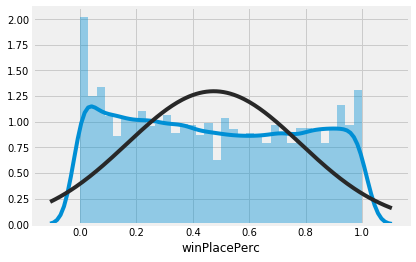

In [10]:
plt.figure()
sns.distplot(train['winPlacePerc'],fit=norm)
plt.show()

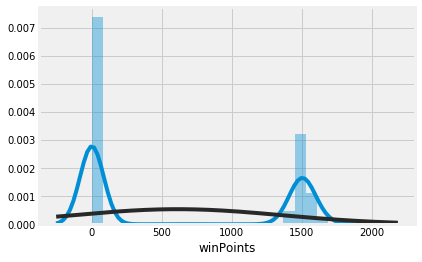

In [11]:
plt.figure()
sns.distplot(train['winPoints'],fit=norm)
plt.show()

In [12]:
train_group=train.groupby('groupId',as_index=False)['winPlacePerc'].agg('mean')

In [13]:
train_group.head()

,groupId,winPlacePerc
0,000025a09dd1d7,0.2000
1,0000c607971e90,0.8085
2,0001456ea42933,0.8587
3,00021aff92b80c,0.0800
4,00033c6a9e27fa,0.2692


In [14]:
train[train['groupId']==2]['winPlacePerc']

Series([], Name: winPlacePerc, dtype: float64)

- From this it is clear that **winPlacePer** which is our target variable is same in each group

###### Match Type 

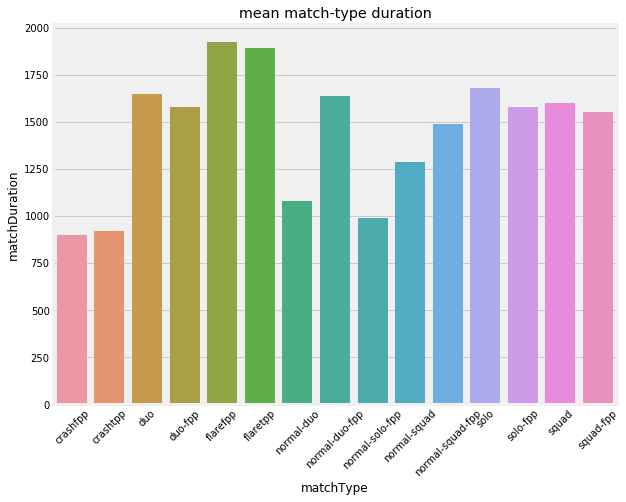

In [15]:
plt.figure(figsize=(9,7))
match_dur=train.groupby('matchType')['matchDuration'].agg('mean')
sns.barplot(x=match_dur.index,y=match_dur)
plt.gca().set_xticklabels(match_dur.index,rotation='45')
plt.gca().set_title('mean match-type duration')
plt.show()

###### Are they correlated ?

In [16]:
train_corr=train.drop(columns=['Id',"matchId","groupId",'matchType'])

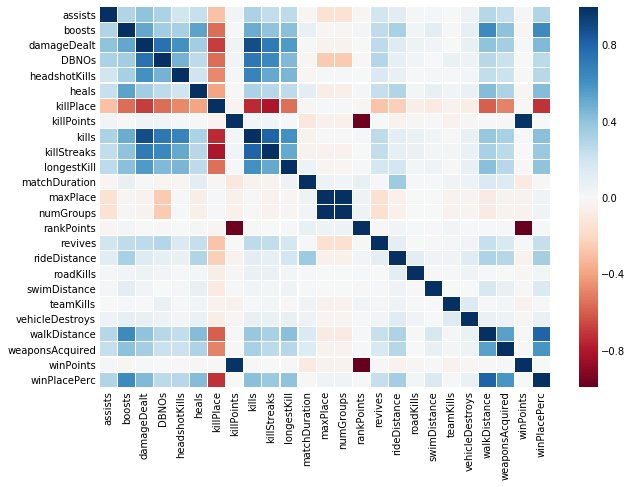

<Figure size 432x288 with 0 Axes>

In [17]:
plt.figure(figsize=(9,7))

sns.heatmap(train_corr.corr(),linewidths=.1,cmap='RdBu')
plt.show()
plt.savefig('corr')

###### Why killplace always shows a negative correlation ?

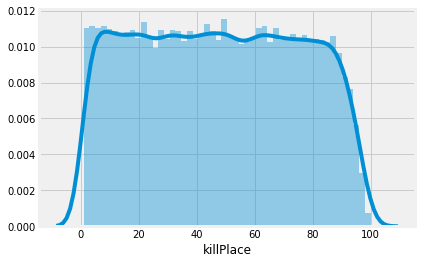

In [18]:
plt.figure()
sns.distplot(train['killPlace'],bins=50)
plt.show()

The **Killplace** feature shows negative correlation between other features because      
killplace is the Ranking in match of number of enemy players killed.

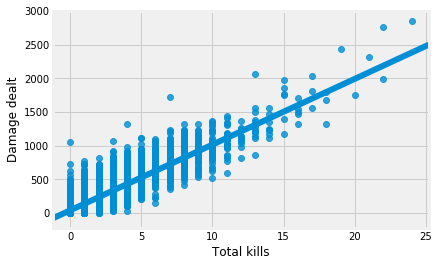

In [19]:
plt.figure()
sns.regplot(train['kills'].values,train['damageDealt'].values)
plt.gca().set_ylabel('Damage dealt')
plt.gca().set_xlabel('Total kills')
plt.show()


## Identifying cheaters

- ######  Types of cheaters

<img src="https://cdn.mos.cms.futurecdn.net/36pdCgyXDgKmbqSpxnJ6Ue-650-80.png">

When it comes to PUBG cheats there are two types of hacks that are pretty common, aim hacks and speed hacks. Both are pretty self explanatory, one makes you speed round the map at a rapid pace, while the other will automatically make sure that your bullets always head towards an opponent. Then there are a number of more subtle cheats that aren’t usually as obvious.

###### PUBG aimbots and hacks

<img src="https://cdn.mos.cms.futurecdn.net/pWwhZzoz8VSA3aYcnapvUo-650-80.jpg">

PUBG aimbots and hacks are probably the most annoying things out there. They will take control of a players aim and automatically target it towards opponents. This can be abused in multiple ways. The most obvious is that every bullet they fire that has a line of sight towards another player will hit, and is the explanation to why other players seem to be able to hit ridiculous cross map shots. 

In [20]:
print("Avergae no of enemy players knocked per game is",train['DBNOs'].sum()/len(train))

Avergae no of enemy players knocked per game is 0.65888


In [21]:
train_dbno=pd.DataFrame(train['DBNOs'].value_counts(),columns=['DBNOs'])
dbno=train_dbno.iloc[:9,:]
dbno.iloc[8]['DBNOs']=train_dbno.iloc[8:,:].sum()['DBNOs']


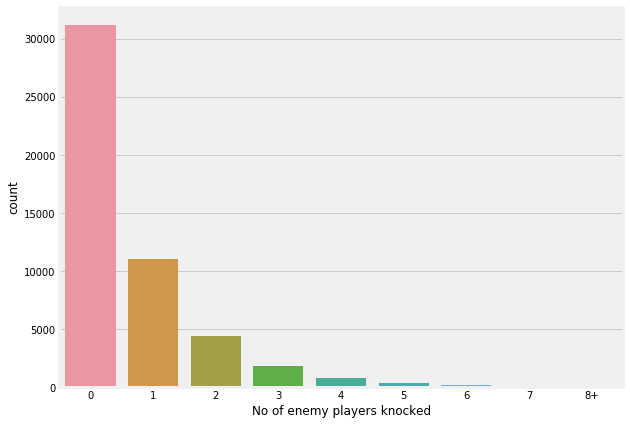

In [22]:
plt.figure(figsize=(9,7))
sns.barplot(dbno.index,dbno.DBNOs)
plt.gca().set_xticklabels([0,1,2,3,4,5,6,7,'8+'])
plt.gca().set_xlabel('No of enemy players knocked')
plt.gca().set_ylabel("count")
plt.show()

In [23]:
print("World record for the most number of DBNOs in a single game is",train_dbno.shape[0])

World record for the most number of DBNOs in a single game is 22


In [24]:
print("A player uses on an avergae {} boost items".format(train['boosts'].sum()/len(train)))

A player uses on an avergae 1.12268 boost items


In [25]:
print("A average player kills {} players".format(train['kills'].sum()/len(train)))

A average player kills 0.9255 players


In [26]:
print('A player uses on an average {}  heals'.format(train['heals'].sum()/len(train)))

A player uses on an average 1.36744  heals


In [27]:
print('A player uses on an average rides {} '.format(train['rideDistance'].sum()/len(train)))

A player uses on an average rides 605.0009338220001 


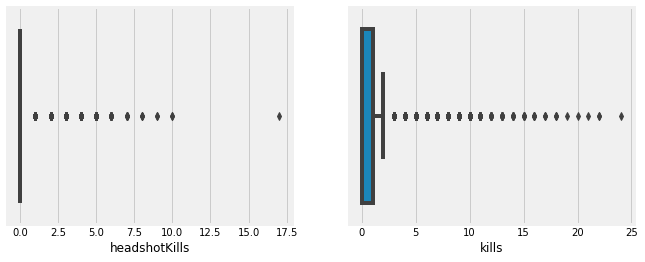

In [28]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_figwidth(10)
sns.boxplot(train['headshotKills'],ax=ax1)
sns.boxplot(train['kills'],ax=ax2)
plt.show()

In [29]:
set1=set(i for i in train[(train['kills']>40) & (train['heals']==0)].index.tolist())


- They might have high headshot rate with aimhacks

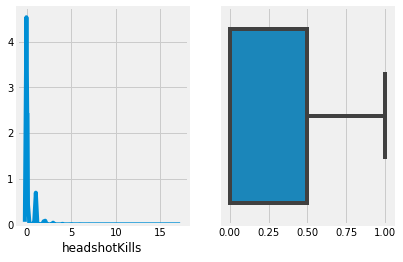

In [30]:
fig,(ax1,ax2)=plt.subplots(1,2)
sns.distplot(train['headshotKills'],ax=ax1)
sns.boxplot(train['headshotKills']/train['kills'],ax=ax2)

- Less movement

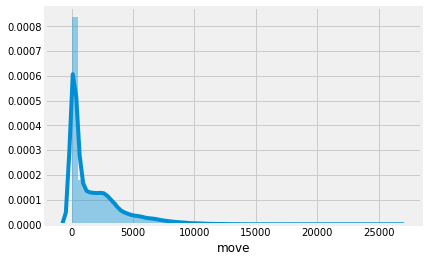

In [31]:
train['move']=train['rideDistance']+train['swimDistance']+train['walkDistance']
test['move']=test['rideDistance']+test['swimDistance']+test['walkDistance']
sns.distplot(train['move'])

In [32]:
set2=set(i for i in train[(train['move']==0) & (train['kills']>20) ].index.tolist())

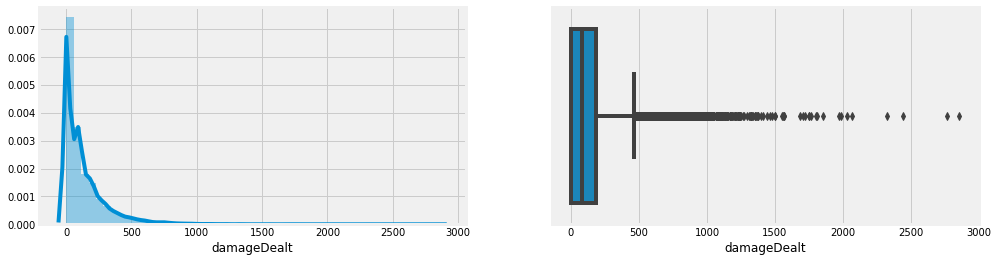

In [33]:

fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_figwidth(15)

sns.distplot(train['damageDealt'],ax=ax1)
sns.boxplot(train['damageDealt'],ax=ax2)
plt.show()

There are outliers in damageDealt.

In [34]:
set3=set(i for i in train[(train['damageDealt']>4000) & (train['heals']<2)].index.tolist())

- ######  PUBG speed Hacks

<img src='https://cdn.mos.cms.futurecdn.net/Vd89dcrLiXGQq4ocje2bTR-650-80.jpg'>

- High ride distance

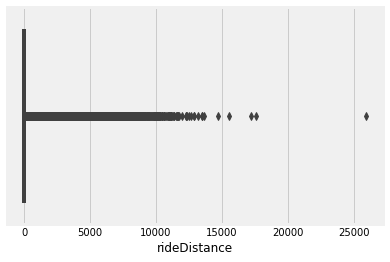

In [35]:
plt.figure()
sns.boxplot(train['rideDistance'])
plt.show()

- High roadkill rate

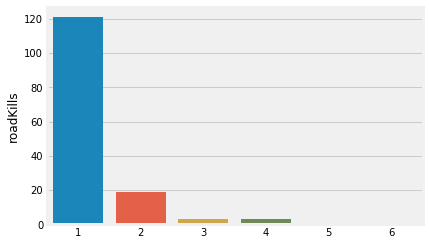

In [36]:
roadkills=train['roadKills'].value_counts()[1:]
sns.barplot(x=roadkills.index,y=roadkills)

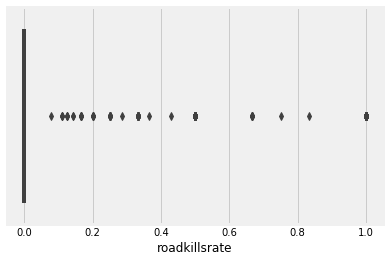

In [37]:
train['roadkillsrate']=(train['roadKills']/train['kills']).fillna(0)
sns.boxplot(train['roadkillsrate'])

plt.show()

In [38]:
set4=set(i for i in train[(train['rideDistance']>25000) & (train['roadkillsrate']>.4) ].index.tolist())

- ###### Recoil Scripts 

<img src='https://cdn.mos.cms.futurecdn.net/LodXF3A7ZFaHt8qNyevcZc-650-80.jpg'>

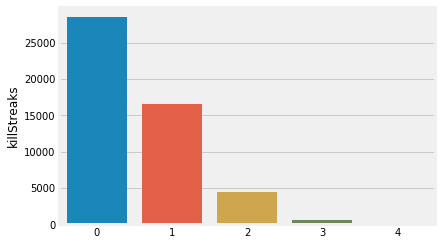

In [39]:
killstreak=pd.DataFrame(train['killStreaks'].value_counts())
killstreak.iloc[4]=killstreak.iloc[4:].sum()
killstreak=killstreak[:5]
sns.barplot(killstreak.index,killstreak['killStreaks'])

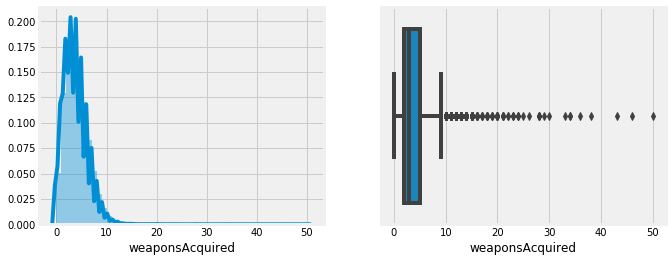

In [40]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_figwidth(10)
sns.distplot(train['weaponsAcquired'],ax=ax1)
sns.boxplot(train['weaponsAcquired'],ax=ax2)

In [41]:
set5=set(i for i in train[(train['killStreaks']>3) & (train['weaponsAcquired']> 30)].index.tolist())

In [42]:
set6=set(i for i in train[(train['killStreaks']>3) & (train['weaponsAcquired']> 30)].index.tolist())

In [43]:
sets=set1 | set2 | set3 | set4 | set5 | set6

In [44]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'move',
       'roadkillsrate'],
      dtype='object')

In [45]:
train.drop(train.index[list(sets)],inplace=True)

#### Feature engineering 

In [46]:
train.drop(['roadkillsrate'],axis=1,inplace=True)

In [47]:
train.columns.drop('winPlacePerc')==test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [48]:
def new_features(df):
    df['items']=df['boosts']+df['heals']
    df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
    df['headshotKills_over_kills'].fillna(0, inplace=True)
    df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
    df['killPlace_over_maxPlace'].fillna(0, inplace=True)
    df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_heals'].fillna(0, inplace=True)
    df['walkDistance_over_heals'].replace(np.inf, 0, inplace=True)
    df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    df['walkDistance_over_kills'].fillna(0, inplace=True)
    df['walkDistance_over_kills'].replace(np.inf, 0, inplace=True)
    df['teamwork'] = df['assists'] + df['revives']
    return df


In [49]:
train=new_features(train)
test=new_features(test)

In [50]:
test.shape

(20000, 35)

In [51]:
train.shape

(50000, 36)

In [52]:
def feature_engineering(is_train=True):
    if is_train: 
        print("processing train.csv")
        df = train
    else:
        print("processing test.csv")
        df = test
    
    target = 'winPlacePerc'
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove('matchType')
    y = None
    if is_train: 
        y = np.array(df.groupby(['matchId','groupId'])[target].agg('mean'), dtype=np.float64)
        features.remove(target)

    print("get group mean feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    if is_train: df_out = agg.reset_index()[['matchId','groupId']]
    else: df_out = df[['matchId','groupId']]

    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group max feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group min feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group size feature")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])
    
    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)
    
    columns=df_out.columns
    X = np.array(df_out, dtype=np.float64)

    del df, df_out, agg, agg_rank
    gc.collect()

    return X, y,columns
    
x_train, y,columns = feature_engineering(True)



processing train.csv
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature


In [53]:
test,z,cb=feature_engineering(False)

processing test.csv
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature


In [54]:
x_train.shape

(49397, 219)

In [55]:
columns

Index(['assists_mean', 'boosts_mean', 'damageDealt_mean', 'DBNOs_mean',
       'headshotKills_mean', 'heals_mean', 'killPlace_mean', 'killPoints_mean',
       'kills_mean', 'killStreaks_mean',
       ...
       'weaponsAcquired', 'winPoints', 'move', 'items',
       'headshotKills_over_kills', 'killPlace_over_maxPlace',
       'walkDistance_over_heals', 'walkDistance_over_kills', 'teamwork',
       'match_size'],
      dtype='object', length=219)

###### MinMax scaling

In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(-1,1),copy=False).fit(x_train)
X_train=scaler.transform(x_train)


In [57]:
x_test=scaler.transform(test)

In [58]:

from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score,KFold
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso,Ridge
from sklearn import preprocessing
from  sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.base import BaseEstimator,RegressorMixin,TransformerMixin,clone

In [59]:
n_folds=2

def mbs(model):
    kf=KFold(n_folds,shuffle=True,random_state=42).get_n_splits(x_train)
    score=-cross_val_score(model,X_train,y,scoring='neg_mean_absolute_error',cv=kf)
    return score
   



In [60]:
lasso=Lasso(alpha=.003,random_state=1)

In [60]:
mbs(lasso)

array([0.1008342 , 0.10115311])

In [63]:
GBoost = GradientBoostingRegressor(n_estimators=600, learning_rate=0.05,
                                   max_depth=4, max_features='auto',
                                   min_samples_leaf=15, min_samples_split=5, 
                                   loss='huber', random_state =5)

In [61]:
#mbs(GBoost)

In [63]:
ridge=Ridge(alpha=0.03,random_state=1)
mbs(ridge)

array([0.08981402, 0.08954514])

In [64]:
lasso.fit(X_train,y)
lasso.predict(x_test)

array([0.23833522, 0.81635713, 0.40937256, ..., 0.72058814, 0.07793215,
       0.70521388])

In [66]:
lasso.score

<bound method RegressorMixin.score of Lasso(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)>

###### XGBoost

In [65]:
params={'learning_rate':[.02,.05,.1],'min_child_weight':[4],'max_depth':[8,10,15],"subsample":[.6,.4],"n_estimators":[300,500]}


In [ ]:
xgb_grid=GridSearchCV(xgb,param_grid=params,cv=2,verbose=True,n_jobs=-1,scoring='neg_mean_absolute_error')
xgb_grid.fit(x_train,y)


Fitting 2 folds for each of 36 candidates, totalling 72 fits


In [212]:

xgb_grid.best_params_

In [62]:
xgb=XGBRegressor(learning_rate=.03,min_child_weight=4,max_depth=10,subsample=.4,n_estimators=500,n_jobs=-1)
#mbs(xgb)
xgb.fit(X_train,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=10, min_child_weight=4, missing=None, n_estimators=500,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.4)

In [63]:
import eli5
from eli5.sklearn import PermutationImportance
per=PermutationImportance(xgb,random_state=42).fit(X_train,y)
eli5.show_weights(per,feature_names=columns)

TypeError: Unexpected feature_names type



#### Stacking

In [67]:
class Average_models(BaseEstimator,RegressorMixin,TransformerMixin):
    def __init__(self,models):
        self.models=models
    def fit(self,X,y):
        self.models_=[clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X,y)
        return self
    def predict(self,X):
            predictions= np.column_stack(model.predict(X) for model in self.models_)
            return np.mean(predictions,axis=1)
            

In [68]:
mbs(Average_models(models=(xgb,GBoost)))

array([0.06177171, 0.06105113])

In [67]:
meta=xgb
meta


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=10, min_child_weight=4, missing=None, n_estimators=500,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.4)

In [71]:
avg=Average_models(models=(xgb,GBoost))
avg.fit(X_train,y)
y_test=avg.predict(x_test)


###### Advanced stacking

In [63]:
training,valid,ytraining,yvalid=train_test_split(X_train,y)
xgb.fit(training,ytraining)
GBoost.fit(training,ytraining)
lasso.fit(training,ytraining)

pred1=xgb.predict(valid)
pred2=GBoost.predict(valid)
pred3=lasso.predict(valid)

#test_pred1=xgb.predict(test)
#test_pred2=GBoost.predict(test)
#test_pred3=lasso.predict(test)

#stacked_predictions=np.column_stack(pred1,pred2,pred3)
#stacked_test_prediction=np.column_stack(test_pred1,test_pred2,test_pred3)

#meta_model=xgb
#meta_model.fit(stacked_predictions,yvalid)
#final=meta_model.predict(stacked_test_prediction)


NameError: name 'GBoost' is not defined

In [88]:
len(valid[0:,0])

12350

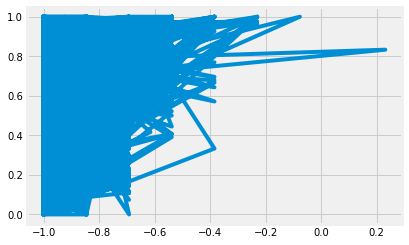

In [89]:
plt.figure()
plt.plot(valid[0:,0],yvalid)



###### Making my submission

In [ ]:
df=pd.DataFrame({'id':test_id.astype('string'),'winPlacePerc':y_test},columns=['id','winPlacePerc'])
csv=df[['id','winPlacePer']].to_csv('/home/shahul/my Datasets/kaggle/ghosts/submission.csv',index=False)

In [231]:
y=y*2-1

In [60]:
#train[['groupId','winPlacePerc']].groupby('groupId').agg('mean')